In [1]:
import numpy as np
import pandas as pd
import string
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nithin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
sms = pd.read_csv('spam.csv', encoding='latin-1')

In [3]:
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Pre-processing

In [4]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

In [5]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000201F83A1438>,
      dtype=object)

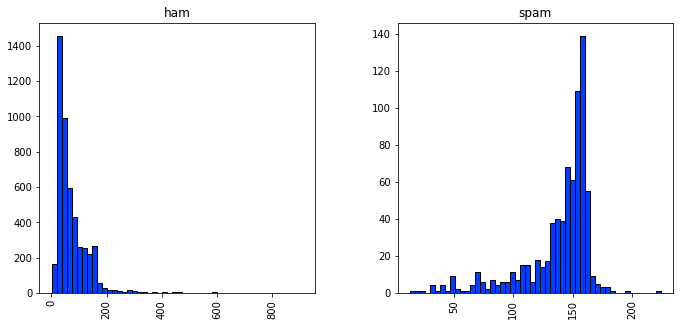

In [8]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

In [9]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [10]:
text_feat = sms['message'].copy()
text_feat = text_feat.apply(text_process)
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_feat)

# Predictions

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [12]:
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

C:\Users\Nithin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# SVC

In [13]:
best_scores = []

In [14]:
def svc(features_train, labels_train, features_test):
    pred_scores = []
    max_pred = []
    max_score = 0.0
    krnl = {'rbf' : 'rbf','polynominal' : 'poly', 'sigmoid': 'sigmoid'}
    for k,v in krnl.items():
        for i in np.linspace(0.05, 1, num=20):
            svc = SVC(kernel=v, gamma=i)
            svc.fit(features_train, labels_train)
            pred = svc.predict(features_test)
            score = accuracy_score(labels_test,pred)
            pred_scores.append((k, [i, score]))
            if score > max_score:
                max_score = score
                max_pred = pred
    return pred_scores, max_pred

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


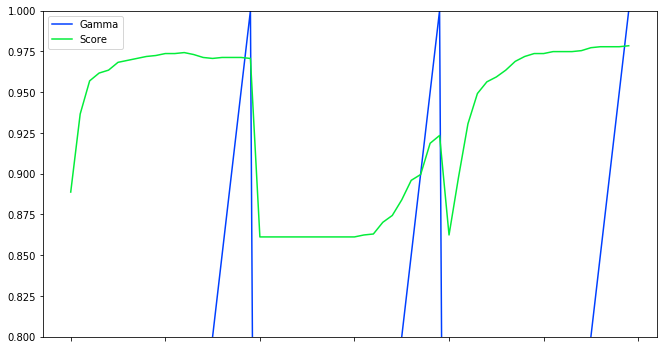

In [15]:
pred_scores, pred = svc(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Gamma','Score'])
df.plot(kind='line', figsize=(11,6), ylim=(0.8,1.0))

In [16]:
df[df['Score'] == df['Score'].max()]

,Gamma,Score
sigmoid,1.0,0.978469


In [17]:
confusion_matrix(labels_test, pred)

array([[1437,    3],
       [  33,  199]], dtype=int64)

In [18]:
best_scores.append(('SVC', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312])]

In [19]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

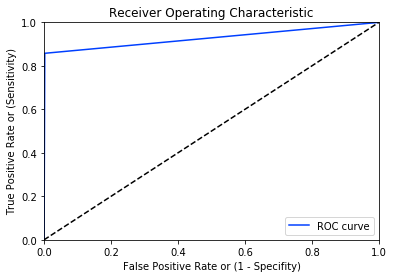

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Decision Tree

In [21]:
def decision_tree(features_train, labels_train, features_test):
    pred_scores = []
    max_score = 0.0
    max_pred = []
    for i in range(2,21):
        dtc = DecisionTreeClassifier(min_samples_split=i, random_state=111)
        dtc.fit(features_train, labels_train)
        pred = dtc.predict(features_test)
        score = accuracy_score(labels_test,pred)
        pred_scores.append((i, [score]))
        if score > max_score:
            max_score = score
            max_pred = pred
    return pred_scores, max_pred

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


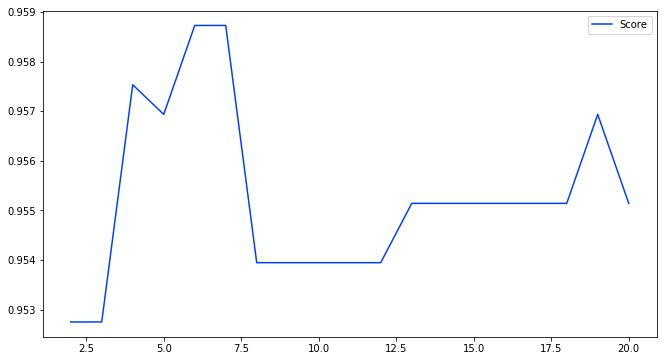

In [22]:
pred_scores, pred = decision_tree(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [23]:
df[df['Score'] == df['Score'].max()]

,Score
6,0.958732
7,0.958732


In [24]:
confusion_matrix(labels_test, pred)

array([[1409,   31],
       [  38,  194]], dtype=int64)

In [25]:
best_scores.append(('Decision Tree', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]), ('Decision Tree', [0.958732057416268])]

In [26]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

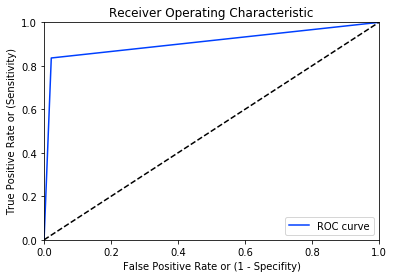

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Ensemble Classifiers

## Random Forest

In [28]:
def random_forest(features_train, labels_train, features_test):
    pred_scores = []
    max_score = 0.0
    max_pred = []
    for i in range(2,50):
        rfc = RandomForestClassifier(n_estimators=i, random_state=111)
        rfc.fit(features_train, labels_train)
        pred = rfc.predict(features_test)
        score = accuracy_score(labels_test,pred)
        pred_scores.append((i, [score]))
        if score > max_score:
            max_score = score
            max_pred = pred
    return pred_scores, max_pred

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


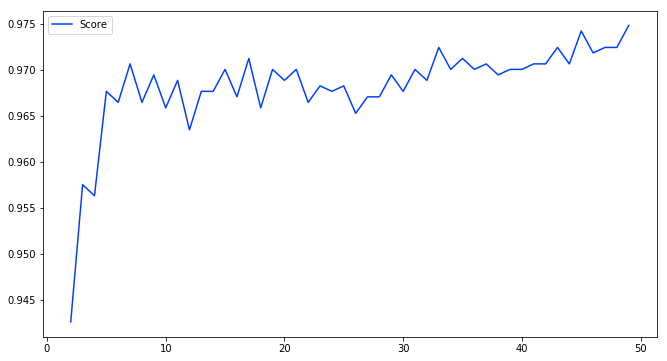

In [29]:
pred_scores, pred = random_forest(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [30]:
df[df['Score'] == df['Score'].max()]

,Score
49,0.97488


In [31]:
confusion_matrix(labels_test, pred)

array([[1440,    0],
       [  42,  190]], dtype=int64)

In [32]:
best_scores.append(('Random Forest', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.958732057416268]),
 ('Random Forest', [0.9748803827751196])]

In [33]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

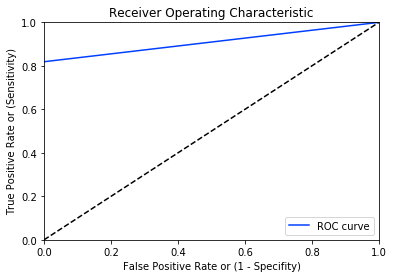

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Adaboost

In [35]:
def adaboost(features_train, labels_train, features_test):
    pred_scores = []
    max_score = 0.0
    max_pred = []
    for i in range(25,76):
        abc = AdaBoostClassifier(n_estimators=i, random_state=111)
        abc.fit(features_train, labels_train)
        pred = abc.predict(features_test)
        score = accuracy_score(labels_test,pred)
        pred_scores.append((i, [score]))
        if score > max_score:
            max_score = score
            max_pred = pred
    return pred_scores, max_pred

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


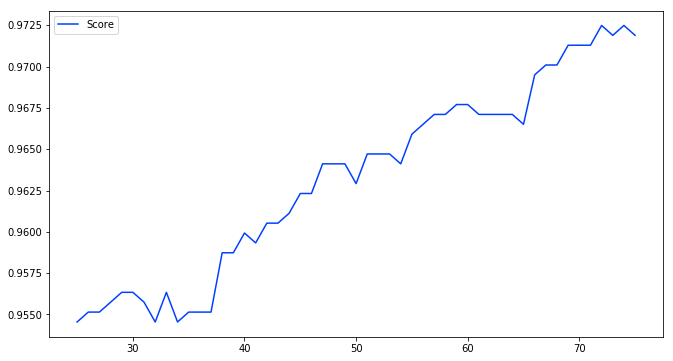

In [36]:
pred_scores, pred = adaboost(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [37]:
df[df['Score'] == df['Score'].max()]

,Score
72,0.972488
74,0.972488


In [38]:
confusion_matrix(labels_test, pred)

array([[1433,    7],
       [  39,  193]], dtype=int64)

In [39]:
best_scores.append(('Adaboost', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.958732057416268]),
 ('Random Forest', [0.9748803827751196]),
 ('Adaboost', [0.972488038277512])]

In [40]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

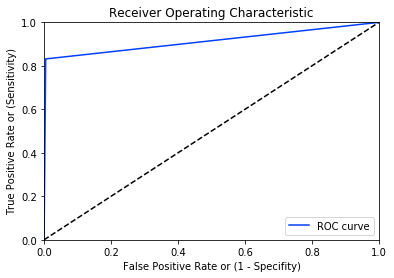

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Bagging

In [42]:
def bagging(features_train, labels_train, features_test):
    pred_scores = []
    max_score = 0.0
    max_pred = []
    for i in range(2,21):
        bc = BaggingClassifier(n_estimators=i, random_state=111)
        bc.fit(features_train, labels_train)
        pred = bc.predict(features_test)
        score = accuracy_score(labels_test,pred)
        pred_scores.append((i, [score]))
        if score > max_score:
            max_score = score
            max_pred = pred
    return pred_scores, max_pred

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


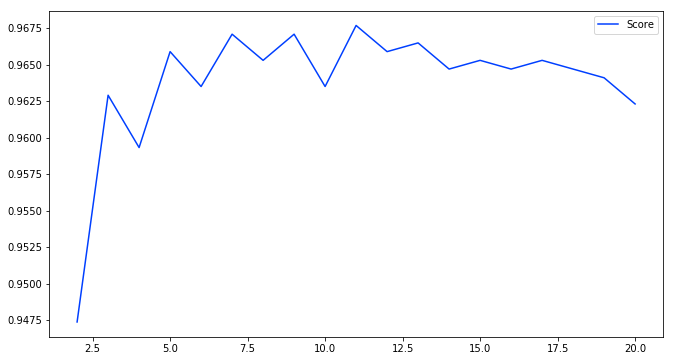

In [43]:
pred_scores, pred = bagging(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [44]:
df[df['Score'] == df['Score'].max()]

,Score
11,0.967703


In [45]:
confusion_matrix(labels_test, pred)

array([[1421,   19],
       [  35,  197]], dtype=int64)

In [46]:
best_scores.append(('Bagging', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.958732057416268]),
 ('Random Forest', [0.9748803827751196]),
 ('Adaboost', [0.972488038277512]),
 ('Bagging', [0.9677033492822966])]

In [47]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

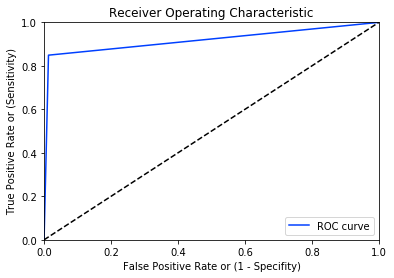

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Extra tree

In [49]:
def extra_tree(features_train, labels_train, features_test):
    pred_scores = []
    max_score = 0.0
    max_pred = []
    for i in range(2,21):
        etc = ExtraTreesClassifier(n_estimators=i, random_state=111)
        etc.fit(features_train, labels_train)
        pred = etc.predict(features_test)
        score = accuracy_score(labels_test,pred)
        pred_scores.append((i, [score]))
        if score > max_score:
            max_score = score
            max_pred = pred
    return pred_scores, max_pred

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


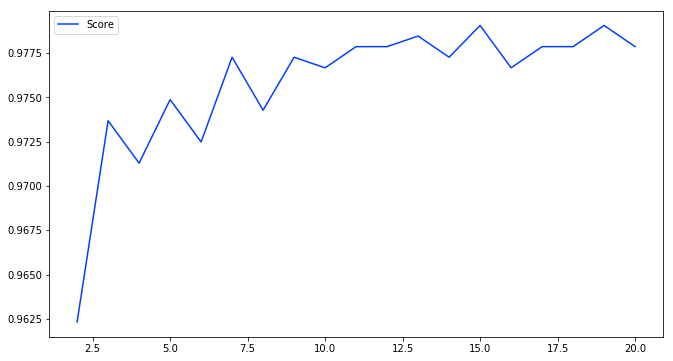

In [50]:
pred_scores, pred = extra_tree(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [51]:
df[df['Score'] == df['Score'].max()]

,Score
15,0.979067
19,0.979067


In [52]:
confusion_matrix(labels_test, pred)

array([[1440,    0],
       [  35,  197]], dtype=int64)

In [53]:
best_scores.append(('Extra Tree', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.958732057416268]),
 ('Random Forest', [0.9748803827751196]),
 ('Adaboost', [0.972488038277512]),
 ('Bagging', [0.9677033492822966]),
 ('Extra Tree', [0.979066985645933])]

In [54]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

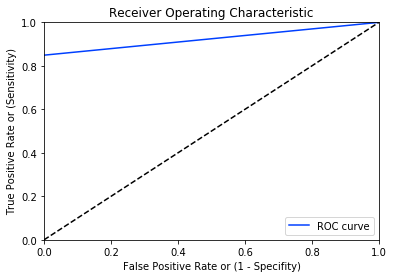

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Naive Bayes

In [56]:
def naive_bayes(features_train, labels_train, features_test):
    pred_scores = []
    max_score = 0.0
    max_pred = []
    for i in np.linspace(0.05, 1, num=20):
        mnb = MultinomialNB(alpha=i)
        mnb.fit(features_train, labels_train)
        pred = mnb.predict(features_test)
        score = accuracy_score(labels_test,pred)
        pred_scores.append((i, [score]))
        if score > max_score:
            max_score = score
            max_pred = pred
    return pred_scores, max_pred

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


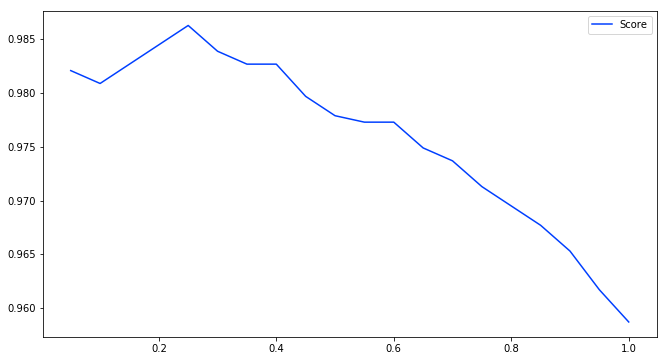

In [57]:
pred_scores, pred = naive_bayes(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [58]:
df[df['Score'] == df['Score'].max()]

,Score
0.25,0.986244


In [59]:
confusion_matrix(labels_test, pred)

array([[1433,    7],
       [  16,  216]], dtype=int64)

In [60]:
best_scores.append(('Naive Bayes', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.958732057416268]),
 ('Random Forest', [0.9748803827751196]),
 ('Adaboost', [0.972488038277512]),
 ('Bagging', [0.9677033492822966]),
 ('Extra Tree', [0.979066985645933]),
 ('Naive Bayes', [0.986244019138756])]

In [61]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

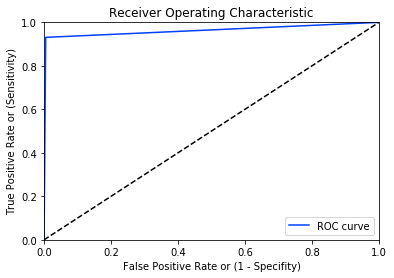

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Logistic Regression

In [63]:
def logitic(features_train, labels_train, features_test):
    pred_scores = []
    max_pred = []
    max_score = 0.0
    for i in np.linspace(1,15,20):
        nb = LogisticRegression(C=i)
        nb.fit(features_train,labels_train)
        pred = nb.predict(features_test)
        score = accuracy_score(labels_test,pred)
        pred_scores.append((i, [score]))
        if score > max_score:
            max_score = score
            max_pred = pred
    return pred_scores, max_pred

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


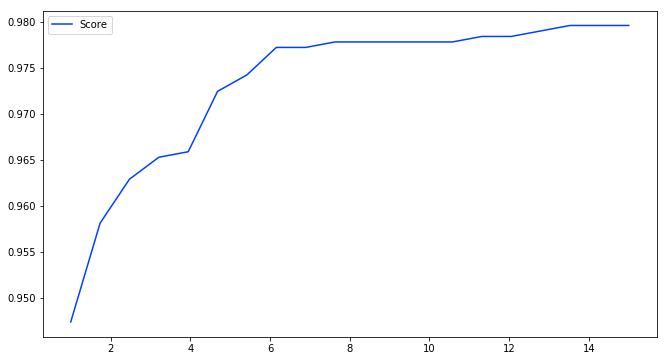

In [64]:
pred_scores, pred = logitic(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [65]:
df[df['Score'] == df['Score'].max()]

,Score
13.526316,0.979665
14.263158,0.979665
15.000000,0.979665


In [66]:
confusion_matrix(labels_test, pred)

array([[1439,    1],
       [  33,  199]], dtype=int64)

In [67]:
best_scores.append(('Logistic Reg', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.958732057416268]),
 ('Random Forest', [0.9748803827751196]),
 ('Adaboost', [0.972488038277512]),
 ('Bagging', [0.9677033492822966]),
 ('Extra Tree', [0.979066985645933]),
 ('Naive Bayes', [0.986244019138756]),
 ('Logistic Reg', [0.9796650717703349])]

In [68]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

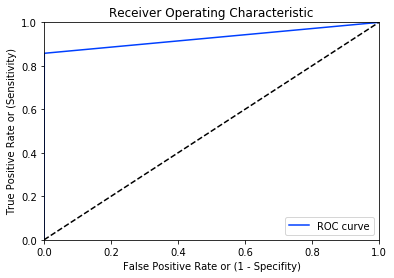

In [69]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# K-nearest

In [70]:
def k_nearest(features_train, labels_train, features_test):
    pred_scores = []
    max_score = 0.0
    max_pred = []
    for i in range(3,61):
        knc = KNeighborsClassifier(n_neighbors=i)
        knc.fit(features_train, labels_train)
        pred = knc.predict(features_test)
        score = accuracy_score(labels_test,pred)
        pred_scores.append((i, [score]))
        if score > max_score:
            max_score = score
            max_pred = pred
    return pred_scores, max_pred

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


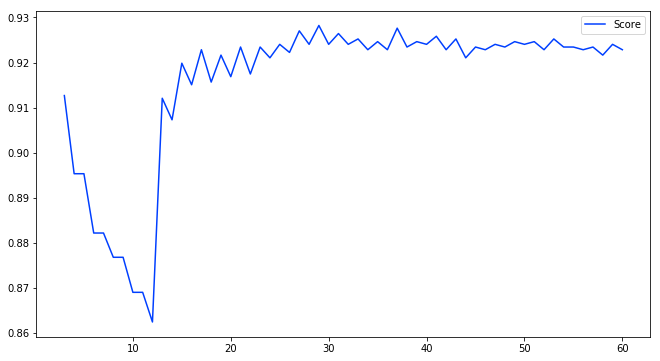

In [71]:
pred_scores, pred = k_nearest(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [72]:
df[df['Score'] == df['Score'].max()]

,Score
29,0.92823


In [73]:
confusion_matrix(labels_test, pred)

array([[1440,    0],
       [ 120,  112]], dtype=int64)

In [74]:
best_scores.append(('K-Nearest', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.958732057416268]),
 ('Random Forest', [0.9748803827751196]),
 ('Adaboost', [0.972488038277512]),
 ('Bagging', [0.9677033492822966]),
 ('Extra Tree', [0.979066985645933]),
 ('Naive Bayes', [0.986244019138756]),
 ('Logistic Reg', [0.9796650717703349]),
 ('K-Nearest', [0.9282296650717703])]

In [75]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

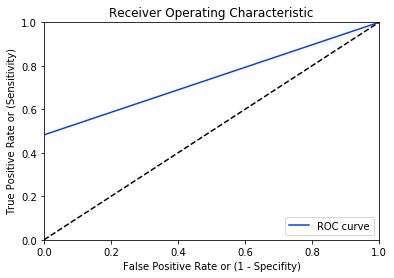

In [76]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [77]:
pred1 = pd.DataFrame.from_items(best_scores,orient='index', columns=['Score'])
pred1

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score
SVC,0.978469
Decision Tree,0.958732
Random Forest,0.974880
Adaboost,0.972488
Bagging,0.967703
Extra Tree,0.979067
Naive Bayes,0.986244
Logistic Reg,0.979665
K-Nearest,0.928230


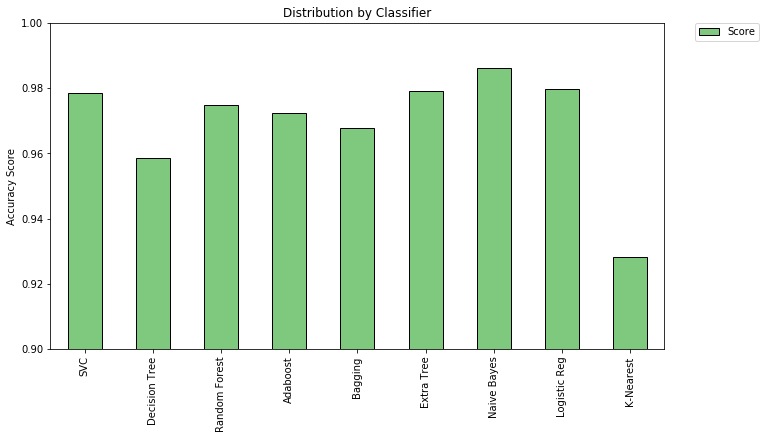

In [78]:
pred1.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9))
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Stemmer

In [79]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

In [80]:
text_feat = text_feat.apply(stemmer)

In [81]:
features = vectorizer.fit_transform(text_feat)

In [82]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

# Predictions 2

# SVC

In [83]:
best_scores = []

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


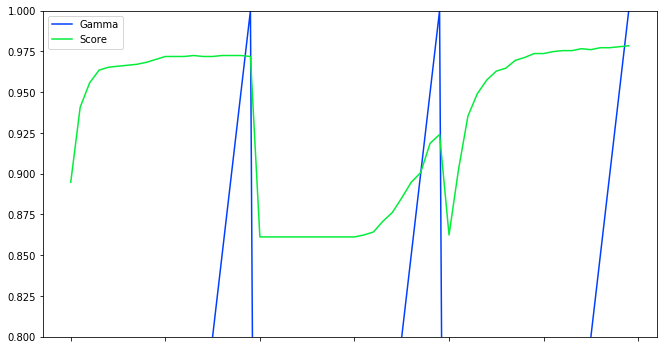

In [84]:
pred_scores, pred = svc(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Gamma','Score'])
df.plot(kind='line', figsize=(11,6), ylim=(0.8,1.0))

In [85]:
df[df['Score'] == df['Score'].max()]

,Gamma,Score
sigmoid,1.0,0.978469


In [86]:
confusion_matrix(labels_test, pred)

array([[1436,    4],
       [  32,  200]], dtype=int64)

In [87]:
best_scores.append(('SVC', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312])]

In [88]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

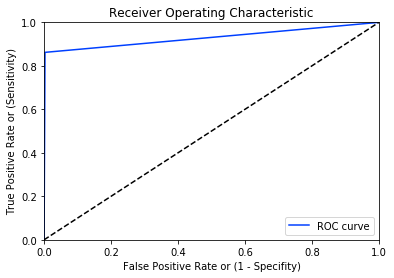

In [89]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Decision Tree

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


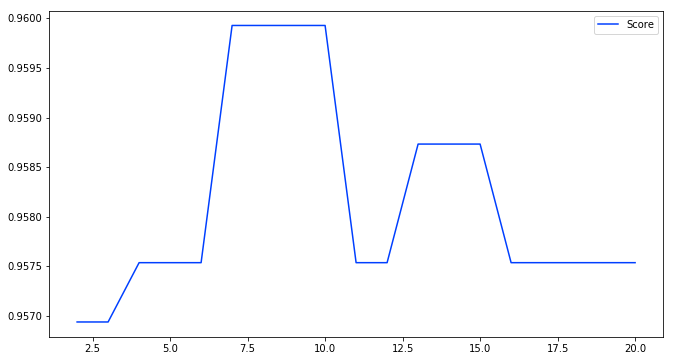

In [90]:
pred_scores, pred = decision_tree(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [91]:
df[df['Score'] == df['Score'].max()]

,Score
7,0.959928
8,0.959928
9,0.959928
10,0.959928


In [92]:
confusion_matrix(labels_test, pred)

array([[1408,   32],
       [  35,  197]], dtype=int64)

In [93]:
best_scores.append(('Decision Tree', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]), ('Decision Tree', [0.9599282296650717])]

In [94]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

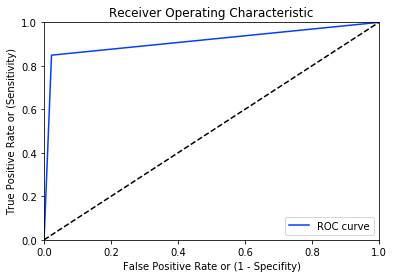

In [95]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Ensemble Classifiers

## Random Forest

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


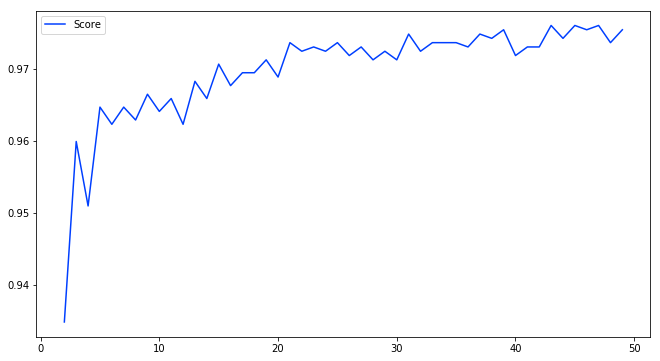

In [96]:
pred_scores, pred = random_forest(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [97]:
df[df['Score'] == df['Score'].max()]

,Score
43,0.976077
45,0.976077
47,0.976077


In [98]:
confusion_matrix(labels_test, pred)

array([[1440,    0],
       [  40,  192]], dtype=int64)

In [99]:
best_scores.append(('Random Forest', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.9599282296650717]),
 ('Random Forest', [0.9760765550239234])]

In [100]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

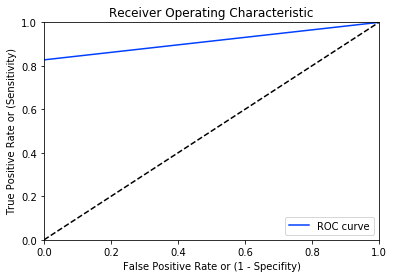

In [101]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Adaboost

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


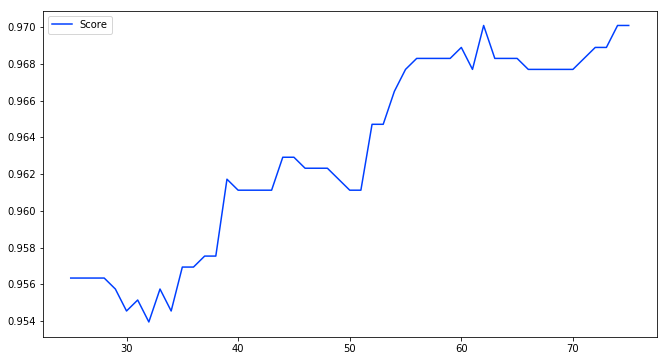

In [102]:
pred_scores, pred = adaboost(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [103]:
df[df['Score'] == df['Score'].max()]

,Score
62,0.970096
74,0.970096
75,0.970096


In [104]:
confusion_matrix(labels_test, pred)

array([[1424,   16],
       [  34,  198]], dtype=int64)

In [105]:
best_scores.append(('Adaboost', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.9599282296650717]),
 ('Random Forest', [0.9760765550239234]),
 ('Adaboost', [0.9700956937799043])]

In [106]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

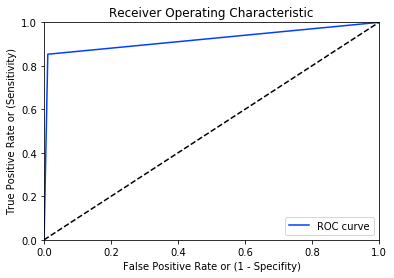

In [107]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Bagging

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


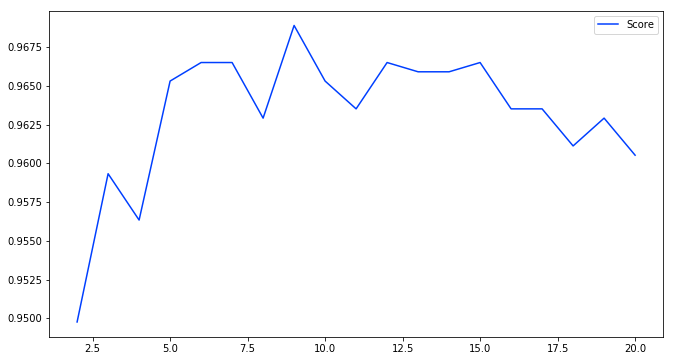

In [108]:
pred_scores, pred = bagging(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [109]:
df[df['Score'] == df['Score'].max()]

,Score
9,0.9689


In [110]:
confusion_matrix(labels_test, pred)

array([[1420,   20],
       [  32,  200]], dtype=int64)

In [111]:
best_scores.append(('Bagging', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.9599282296650717]),
 ('Random Forest', [0.9760765550239234]),
 ('Adaboost', [0.9700956937799043]),
 ('Bagging', [0.9688995215311005])]

In [112]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

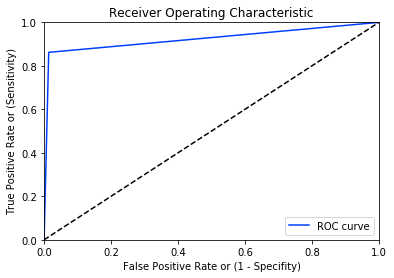

In [113]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Extra tree

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


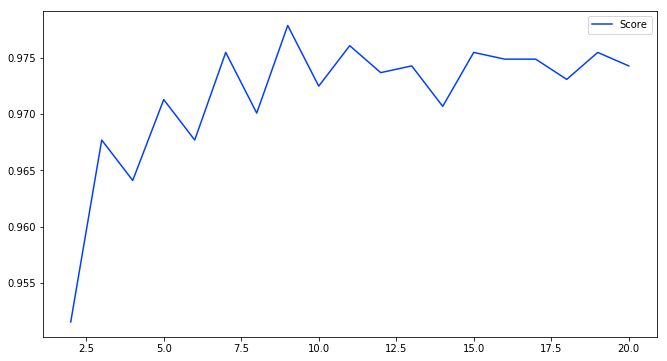

In [114]:
pred_scores, pred = extra_tree(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [115]:
df[df['Score'] == df['Score'].max()]

,Score
9,0.977871


In [116]:
confusion_matrix(labels_test, pred)

array([[1437,    3],
       [  34,  198]], dtype=int64)

In [117]:
best_scores.append(('Extra Tree', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.9599282296650717]),
 ('Random Forest', [0.9760765550239234]),
 ('Adaboost', [0.9700956937799043]),
 ('Bagging', [0.9688995215311005]),
 ('Extra Tree', [0.9778708133971292])]

In [118]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

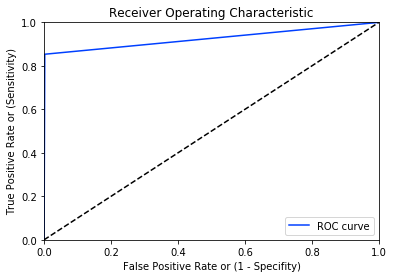

In [119]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Naive Bayes

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


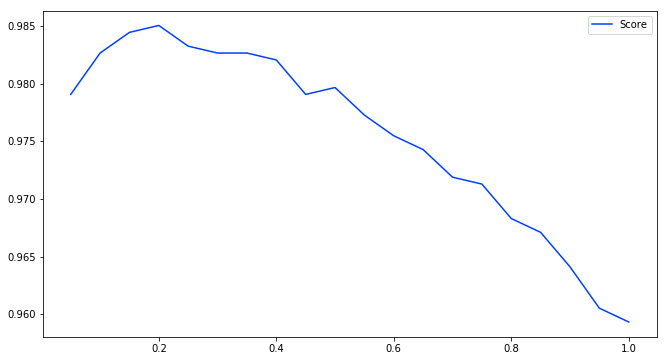

In [120]:
pred_scores, pred = naive_bayes(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [121]:
df[df['Score'] == df['Score'].max()]

,Score
0.2,0.985048


In [122]:
confusion_matrix(labels_test, pred)

array([[1429,   11],
       [  14,  218]], dtype=int64)

In [123]:
best_scores.append(('Naive Bayes', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.9599282296650717]),
 ('Random Forest', [0.9760765550239234]),
 ('Adaboost', [0.9700956937799043]),
 ('Bagging', [0.9688995215311005]),
 ('Extra Tree', [0.9778708133971292]),
 ('Naive Bayes', [0.9850478468899522])]

In [124]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

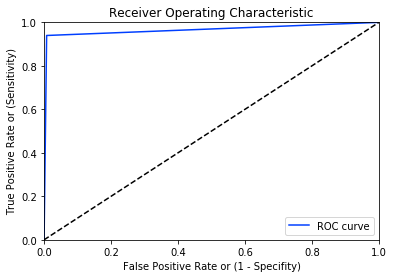

In [125]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Logistic Regression

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


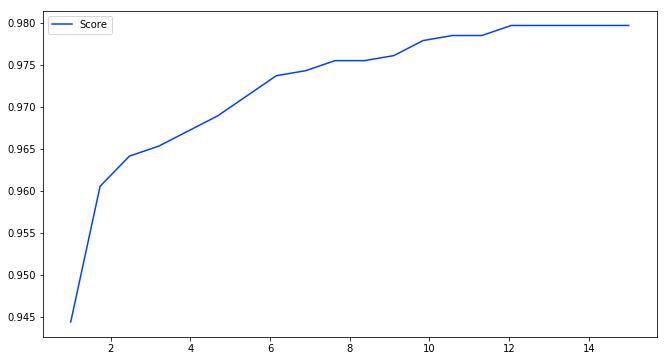

In [126]:
pred_scores, pred = logitic(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [127]:
df[df['Score'] == df['Score'].max()]

,Score
12.052632,0.979665
12.789474,0.979665
13.526316,0.979665
14.263158,0.979665
15.000000,0.979665


In [128]:
confusion_matrix(labels_test, pred)

array([[1438,    2],
       [  32,  200]], dtype=int64)

In [129]:
best_scores.append(('Logistic Reg', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.9599282296650717]),
 ('Random Forest', [0.9760765550239234]),
 ('Adaboost', [0.9700956937799043]),
 ('Bagging', [0.9688995215311005]),
 ('Extra Tree', [0.9778708133971292]),
 ('Naive Bayes', [0.9850478468899522]),
 ('Logistic Reg', [0.9796650717703349])]

In [130]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

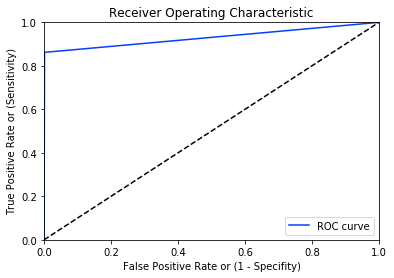

In [131]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# K-nearest

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


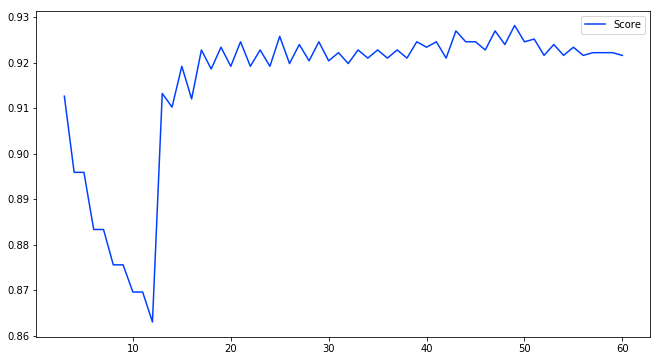

In [132]:
pred_scores, pred = k_nearest(features_train, labels_train, features_test)
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))

In [133]:
df[df['Score'] == df['Score'].max()]

,Score
49,0.92823


In [134]:
confusion_matrix(roc_true, roc_pred)

array([[1438,    2],
       [  32,  200]], dtype=int64)

In [135]:
best_scores.append(('K-Nearest', [df['Score'].max()]))
best_scores

[('SVC', [0.9784688995215312]),
 ('Decision Tree', [0.9599282296650717]),
 ('Random Forest', [0.9760765550239234]),
 ('Adaboost', [0.9700956937799043]),
 ('Bagging', [0.9688995215311005]),
 ('Extra Tree', [0.9778708133971292]),
 ('Naive Bayes', [0.9850478468899522]),
 ('Logistic Reg', [0.9796650717703349]),
 ('K-Nearest', [0.9282296650717703])]

In [136]:
roc_true = np.array(labels_test)
roc_true = (roc_true=="spam").astype(int)
roc_pred = np.array(pred)
roc_pred = (roc_pred=="spam").astype(int)

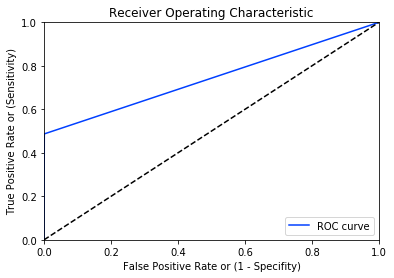

In [137]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(roc_true, roc_pred,)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [138]:
pred2 = pd.DataFrame.from_items(best_scores,orient='index', columns=['Score2'])
pred1 = pd.concat([pred1,pred2],axis=1)

C:\Users\Nithin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


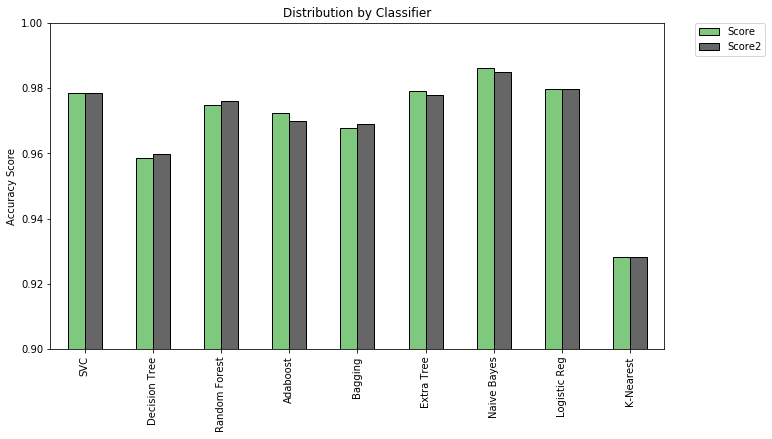

In [139]:
pred1.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9))
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [140]:
pred1

,Score,Score2
SVC,0.978469,0.978469
Decision Tree,0.958732,0.959928
Random Forest,0.974880,0.976077
Adaboost,0.972488,0.970096
Bagging,0.967703,0.968900
Extra Tree,0.979067,0.977871
Naive Bayes,0.986244,0.985048
Logistic Reg,0.979665,0.979665
K-Nearest,0.928230,0.928230


# Adding length parameter

## Char count

In [141]:
messages = pd.Series(sms['message'].tolist()).astype(str)
ham_messages = pd.Series(sms[sms['label'] == 'ham']['message'].tolist()).astype(str)
spam_messages = pd.Series(sms[sms['label'] == 'spam']['message'].tolist()).astype(str)

dist_all = messages.apply(len)
dist_ham = ham_messages.apply(len)
dist_spam = spam_messages.apply(len)

C:\Users\Nithin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


# Summary statistics for character count of all messages
mean-all 80.12 
std-all 59.69 
min-all 2.00 
max-all 910.00


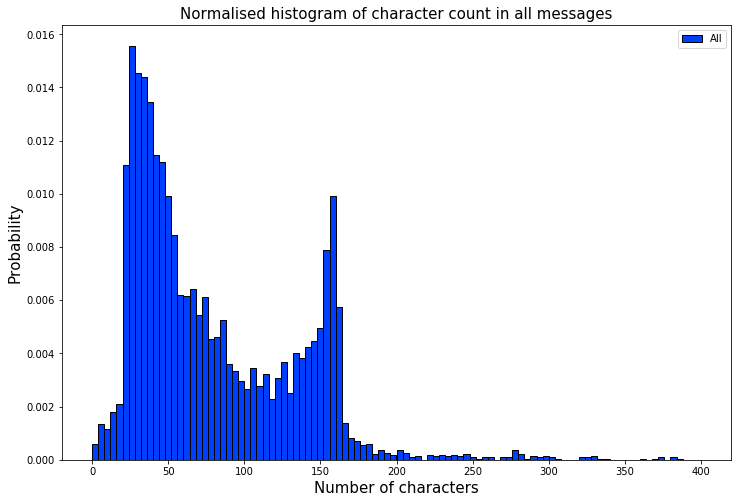

In [142]:
plt.figure(figsize=(12, 8))
plt.hist(dist_all, bins=100, range=[0,400], normed=True, label='All')
plt.title('Normalised histogram of character count in all messages', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for character count of all messages')
print('mean-all {:.2f} \nstd-all {:.2f} \nmin-all {:.2f} \nmax-all {:.2f}'.format(dist_all.mean(), 
                          dist_all.std(), dist_all.min(), dist_all.max()))

C:\Users\Nithin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


# Summary statistics for character count of ham vs spam messages
mean-ham  71.02   mean-spam 138.87 
std-ham   58.02   std-spam   29.18 
min-ham    2.00   min-ham    13.00 
max-ham  910.00   max-spam  224.00


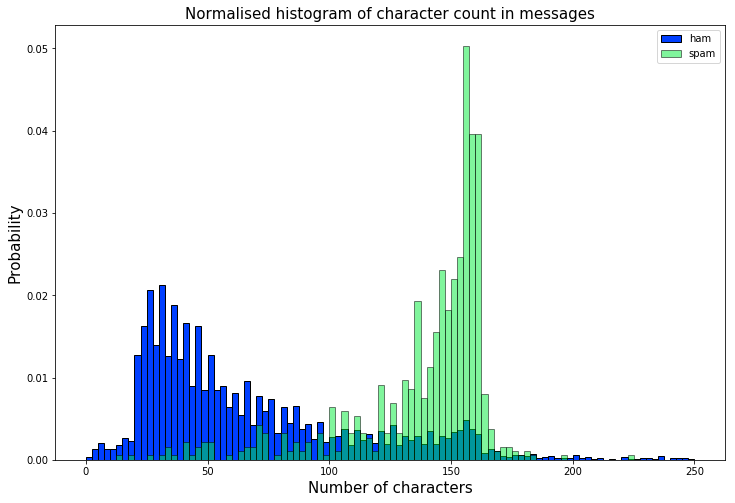

In [143]:
plt.figure(figsize=(12,8))
plt.hist(dist_ham, bins=100, range=[0,250], normed=True, label='ham')
plt.hist(dist_spam, bins=100, range=[0, 250], normed=True, alpha=0.5, label='spam')
plt.title('Normalised histogram of character count in messages', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for character count of ham vs spam messages')
print('mean-ham  {:.2f}   mean-spam {:.2f} \nstd-ham   {:.2f}   std-spam   {:.2f} \nmin-ham    {:.2f}   min-ham    {:.2f} \nmax-ham  {:.2f}   max-spam  {:.2f}'.format(dist_ham.mean(), 
                         dist_spam.mean(), dist_ham.std(), dist_spam.std(), dist_ham.min(), dist_spam.min(), dist_ham.max(), dist_spam.max()))

## Word Count

In [144]:
dist_all = messages.apply(lambda x: len(x.split(' ')))
dist_ham = ham_messages.apply(lambda x: len(x.split(' ')))
dist_spam = spam_messages.apply(lambda x: len(x.split(' ')))

C:\Users\Nithin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


# Summary statistics for word count of all messages
mean-all 15.61 
std-all 11.42 
min-all 1.00 
max-all 171.00


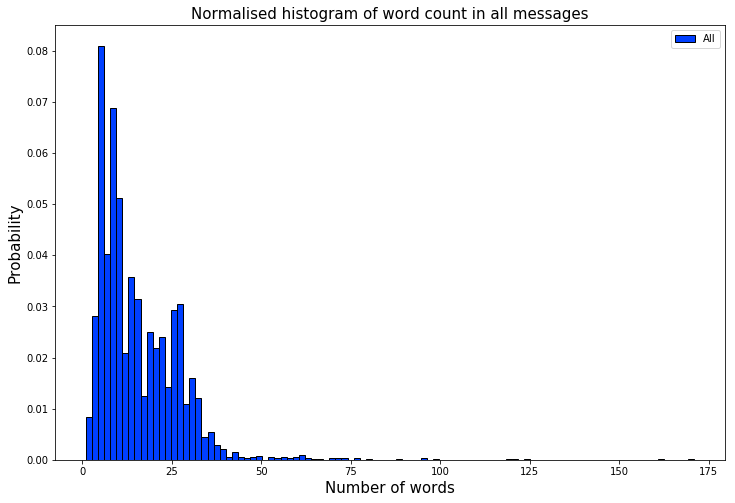

In [145]:
plt.figure(figsize=(12, 8))
plt.hist(dist_all, bins=100, normed=True, label='All')
plt.title('Normalised histogram of word count in all messages', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for word count of all messages')
print('mean-all {:.2f} \nstd-all {:.2f} \nmin-all {:.2f} \nmax-all {:.2f}'.format(dist_all.mean(), 
                          dist_all.std(), dist_all.min(), dist_all.max()))

C:\Users\Nithin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


# Summary statistics for word count of ham vs spam messages
mean-ham  14.32   mean-spam 23.89 
std-ham   11.54   std-spam   5.83 
min-ham    1.00   min-ham    2.00 
max-ham  171.00   max-spam  35.00


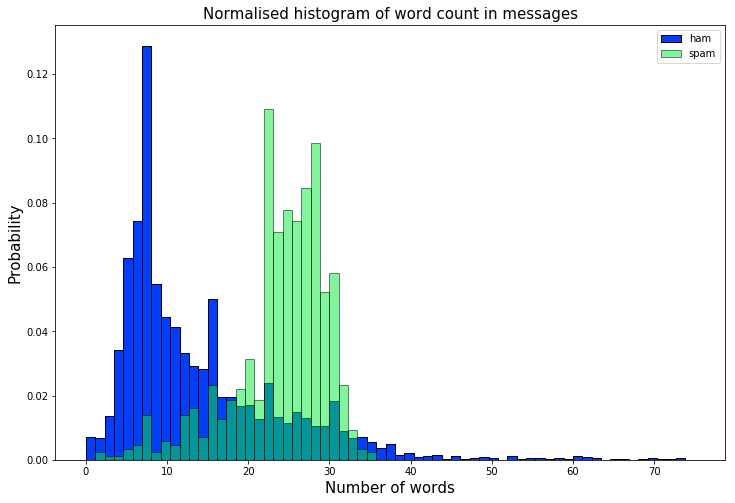

In [146]:
plt.figure(figsize=(12,8))
plt.hist(dist_ham, bins=65, range=[0,75], normed=True, label='ham')
plt.hist(dist_spam, bins=65, range=[0, 75], normed=True, alpha=0.5, label='spam')
plt.title('Normalised histogram of word count in messages', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for word count of ham vs spam messages')
print('mean-ham  {:.2f}   mean-spam {:.2f} \nstd-ham   {:.2f}   std-spam   {:.2f} \nmin-ham    {:.2f}   min-ham    {:.2f} \nmax-ham  {:.2f}   max-spam  {:.2f}'.format(dist_ham.mean(), 
                         dist_spam.mean(), dist_ham.std(), dist_spam.std(), dist_ham.min(), dist_spam.min(), dist_ham.max(), dist_spam.max()))